In [17]:
import numpy as np
import pandas as pd
import pyfolio as pf
import timeit

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
# Read in data
data = pd.read_csv(r'C:\Users\Drey\finlab_ml_course\training_data\2330.csv')
data = data.sort_values(by=['date'])
data.index = pd.to_datetime(data['date'])
data = data.drop('date', axis=1)
data = data.drop('index', axis=1)
data['side'] = data['side'].apply(lambda x:1 if x == 1 else 0)

<AxesSubplot:>

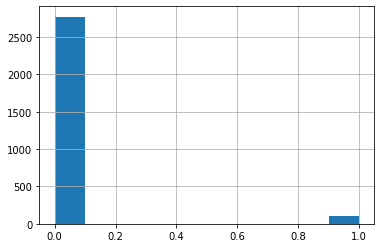

In [19]:
data.side.hist()

In [20]:
primary_forecast = pd.DataFrame(data[['out', 'side']])
# primary_forecast['side'] = primary_forecast['side'].apply(lambda x:1 if x == -1 else 0)
primary_forecast = primary_forecast[primary_forecast['side'] == 1]
primary_forecast.side = primary_forecast.side.astype(int)
primary_forecast.columns = ['actual', 'pred']
# primary_forecast['actual'] = primary_forecast['actual'].apply(lambda x:1 if x == 1 else 0)
# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.51      1.00      0.68        56

    accuracy                           0.51       109
   macro avg       0.26      0.50      0.34       109
weighted avg       0.26      0.51      0.35       109

Confusion Matrix
[[ 0 53]
 [ 0 56]]

Accuracy
0.5137614678899083


C:\Users\Drey\anaconda3\envs\finlab\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
import joblib
rf = joblib.load(r'C:\Users\Drey\finlab_ml_course\lazypredict\XGBoost.pkl')

In [22]:
feature_list = ['com_rev', 'd_yield', 'pb', 'AD', 'OBV', 'ADOSC', 'bias5',
       'bias10', 'bias20', 'bias60', 'acc5', 'acc10', 'acc20', 'acc60', 'rsi',
       'log_ret', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'volatility',
       'autocorr_1', 'autocorr_2', 'autocorr_3', 'autocorr_4', 'autocorr_5',
       'log_t1', 'log_t2', 'log_t3', 'log_t4', 'log_t5', 'b_acc5', 'b_acc15', 'side', 'out']
training_data = data[feature_list][data.side == 1]
#取testing data
train_data = training_data.iloc[:int(training_data.shape[0]*.7),:]
print(train_data.shape)
test_data = training_data.iloc[int(training_data.shape[0]*.7):,:]
print(test_data.shape)

(76, 36)
(33, 36)


In [28]:
X_train = training_data.iloc[:,:-2]
y_train = training_data.iloc[:,-1]
X_test = test_data.iloc[:,:-2]
y_test = test_data.iloc[:,-1]

              precision    recall  f1-score   support

           0       0.62      0.57      0.59        53
           1       0.62      0.68      0.65        56

    accuracy                           0.62       109
   macro avg       0.62      0.62      0.62       109
weighted avg       0.62      0.62      0.62       109

Confusion Matrix
[[30 23]
 [18 38]]

Accuracy
0.6238532110091743


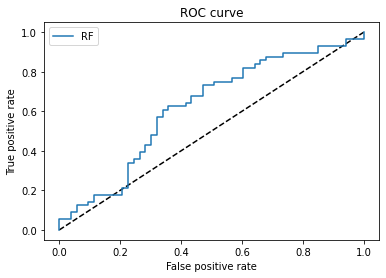

In [37]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

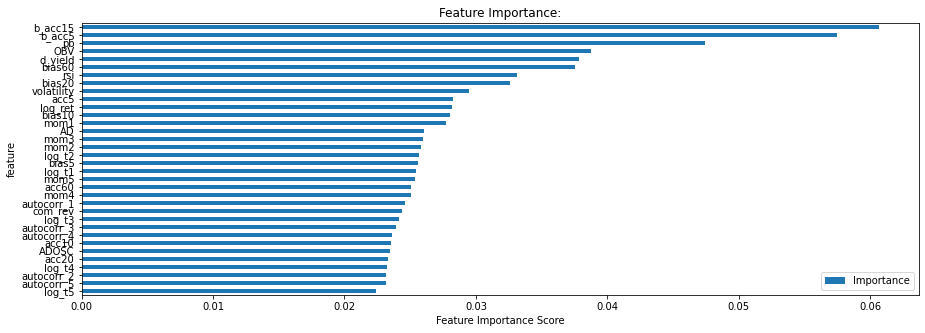

In [31]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = training_data.iloc[:,:-2].columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

In [32]:
perf_func = pf.timeseries.perf_stats

In [33]:
def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

In [34]:
data.head()

,close,open,high,low,volume,rev,com_rev,d_yield,pb,b_acc5,...,log_t1,log_t2,log_t3,log_t4,log_t5,fast_mavg,slow_mavg,sma,out,ret
date,,,,,,,,,,,,,,,,,,,,,
2010-07-01,60.0,60.6,60.6,59.9,65215602.0,33839484.0,0.396008,0.970109,0.033994,0.737259,...,0.390491,0.361524,0.459162,0.371630,0.420275,61.257143,61.460000,-1.0,1,0.020138
2010-07-02,60.3,60.0,60.7,60.0,67300030.0,33839484.0,0.396008,0.964674,0.036827,0.667339,...,0.370276,0.390491,0.361524,0.459162,0.371630,61.000000,61.520000,-1.0,0,-0.014267
2010-07-05,61.4,60.3,61.8,60.3,88484101.0,33839484.0,0.396008,0.940217,0.043909,0.591211,...,0.459843,0.370276,0.390491,0.361524,0.459162,60.914286,61.580000,-1.0,0,-0.023697
2010-07-06,59.9,58.9,59.9,58.8,69857079.0,33839484.0,0.396008,0.972826,0.033994,0.538853,...,0.538331,0.459843,0.370276,0.390491,0.361524,60.700000,61.500000,-1.0,1,0.025402
2010-07-07,59.5,59.8,59.9,59.2,59168632.0,33839484.0,0.396008,0.983696,0.031161,0.483141,...,0.281638,0.538331,0.459843,0.370276,0.390491,60.385714,61.373333,-1.0,1,0.024299


In [39]:
test_dates = data[data['side'] == 1].index

base_rets = data.loc[test_dates, 'ret']
# base_rets = labels['ret']
primary_model_rets = get_daily_returns(base_rets)

# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_model_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")
perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])

# pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)
pf.show_perf_stats(primary_model_rets)

C:\Users\Drey\anaconda3\envs\finlab\lib\site-packages\empyrical\stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
C:\Users\Drey\anaconda3\envs\finlab\lib\site-packages\empyrical\stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Start date,2011-02-14
End date,2022-03-08
Total months,137
,Backtest
Annual return,4.771%
Cumulative returns,70.573%
Annual volatility,8.777%
Sharpe ratio,0.57
Calmar ratio,0.36
Stability,0.81
Max drawdown,-13.323%


In [40]:
test_dates = X_train.index

meta_returns = data.loc[test_dates, 'ret'] * y_pred
daily_meta_rets = get_daily_returns(meta_returns)

# save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_meta_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model'] = perf_stats_all

# pf.create_returns_tear_sheet(meta_returns, benchmark_rets=None)
pf.show_perf_stats(daily_meta_rets)

C:\Users\Drey\anaconda3\envs\finlab\lib\site-packages\empyrical\stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
C:\Users\Drey\anaconda3\envs\finlab\lib\site-packages\empyrical\stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Start date,2011-02-14
End date,2022-03-08
Total months,137
,Backtest
Annual return,4.592%
Cumulative returns,67.252%
Annual volatility,6.352%
Sharpe ratio,0.74
Calmar ratio,0.31
Stability,0.88
Max drawdown,-14.926%


C:\Users\Drey\anaconda3\envs\finlab\lib\site-packages\empyrical\stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
C:\Users\Drey\anaconda3\envs\finlab\lib\site-packages\empyrical\stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Start date,2011-02-14
End date,2022-03-08
Total months,137
,Backtest
Annual return,4.592%
Cumulative returns,67.252%
Annual volatility,6.352%
Sharpe ratio,0.74
Calmar ratio,0.31
Stability,0.88
Max drawdown,-14.926%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,14.93,2018-10-04,2019-05-21,2021-03-25,646
1,5.94,2022-02-24,2022-03-01,NaT,NaN
2,4.64,2013-11-08,2015-06-03,2015-06-08,412
3,3.75,2015-08-11,2016-04-29,2017-04-19,442
4,2.67,2017-11-27,2017-11-28,2017-11-30,4


C:\Users\Drey\anaconda3\envs\finlab\lib\site-packages\pandas\plotting\_matplotlib\tools.py:321: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
C:\Users\Drey\anaconda3\envs\finlab\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Drey\anaconda3\envs\finlab\lib\site-packages\pandas\plotting\_matplotlib\tools.py:321: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
C:\Users\Drey\anaconda3\envs\finlab\lib\site-packages\pandas\plotting\_matplotlib\tools.py:

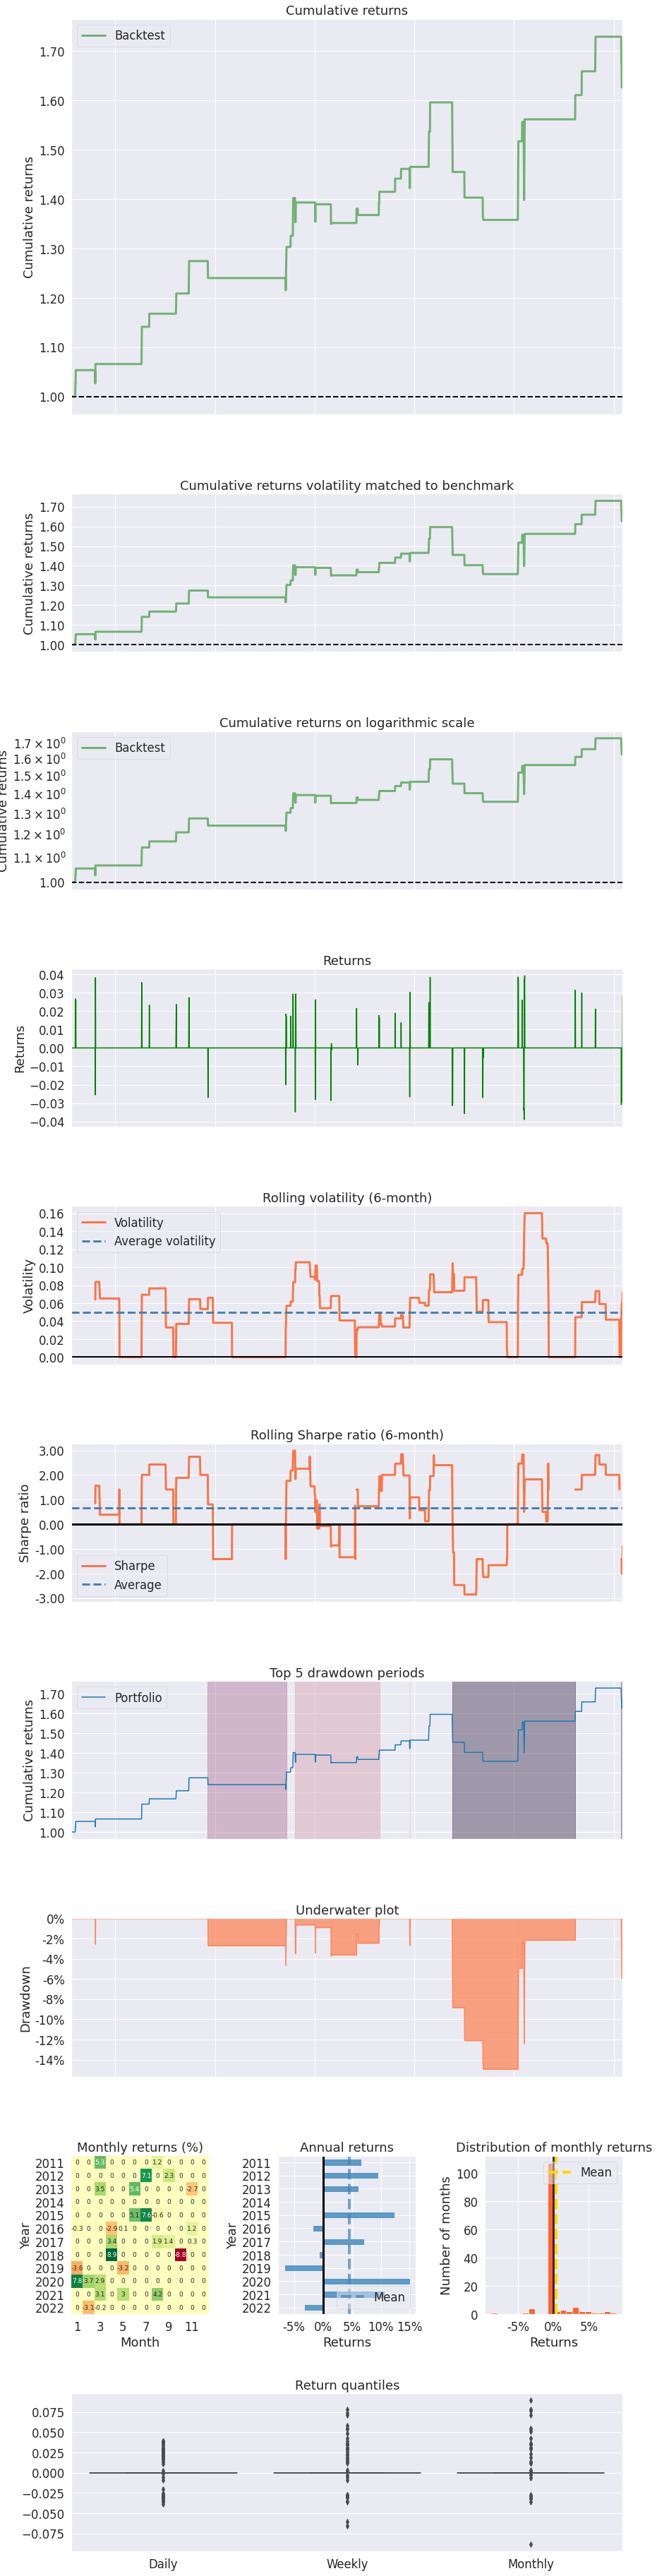

In [42]:
test_dates = X_train.index
meta_returns = data.loc[test_dates, 'ret'] * y_pred
daily_rets_meta = get_daily_returns(meta_returns)

# save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_rets_meta, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model OOS'] = perf_stats_all

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)